# Notebook 04: Clustering

**Objective**: Identify distinct cell populations using graph-based clustering.

## What you will learn:
- Graph-based clustering (Leiden algorithm)
- How to choose resolution parameter
- Evaluate clustering quality
- Visualize clusters on UMAP
- Analyze cluster composition

## Why Clustering?

Cells with similar expression profiles likely belong to the same **cell type** or **cell state**.

**Goal**: Group cells into clusters that represent biological populations (T cells, B cells, monocytes, etc.)

## Graph-Based Clustering

We use the **Leiden algorithm**:
- Works on the neighborhood graph (computed in Notebook 03)
- Finds communities of densely connected cells
- Fast and scalable
- Better than older methods (Louvain, k-means)

## Key Parameter: Resolution

**Resolution** controls cluster granularity:
- **Low resolution (0.1-0.5)**: Few large clusters (broad cell types)
- **Medium resolution (0.8-1.2)**: Balanced (standard choice)
- **High resolution (2.0+)**: Many small clusters (cell subtypes)

## Workflow:
1. Load data with UMAP
2. Perform Leiden clustering (multiple resolutions)
3. Visualize clusters on UMAP
4. Evaluate clustering quality
5. Choose optimal resolution
6. Save clustered data

In [2]:
# Import libraries
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure Scanpy
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Paths
data_dir = '../data/'
results_dir = '../results/'

print("Libraries imported successfully!")
print(f"Scanpy version: {sc.__version__}")

Libraries imported successfully!
Scanpy version: 1.11.4


## 1. Load Data

Load the data from Notebook 03 with PCA, UMAP, and neighborhood graph.

In [4]:
# Load data with dimensionality reduction
adata = sc.read_h5ad(f'{data_dir}pbmc3k_dimred.h5ad')

print("=" * 60)
print("LOADED DATA")
print("=" * 60)
print(adata)
print(f"Dimensions: {adata.shape[0]} cells × {adata.shape[1]} genes")
print(f"PCA: {adata.obsm['X_pca'].shape}")
print(f"UMAP: {adata.obsm['X_umap'].shape}")
print(f"Neighbors graph: {'connectivities' in adata.obsp}")

LOADED DATA
AnnData object with n_obs × n_vars = 2689 × 13671
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'
Dimensions: 2689 cells × 13671 genes
PCA: (2689, 50)
UMAP: (2689, 2)
Neighbors graph: True


## 2. Leiden Clustering

### What is Leiden?

**Leiden algorithm**:
- Optimizes modularity (how well-separated clusters are)
- Finds communities in the neighborhood graph
- Deterministic with fixed random seed
- Improved version of Louvain algorithm

### Resolution Parameter

We'll test multiple resolutions to find the optimal granularity.

In [6]:
# Leiden clustering with default resolution (1.0)
sc.tl.leiden(adata, resolution=1.0, key_added='leiden_1.0')

print("✅ Leiden clustering complete!")
print(f"Number of clusters: {adata.obs['leiden_1.0'].nunique()}")
print(f"\nCluster sizes:")
print(adata.obs['leiden_1.0'].value_counts().sort_index())

running Leiden clustering


/var/folders/n_/13l5tlhj4zv27nrjmh1_htdw0000gn/T/ipykernel_28306/1444104657.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=1.0, key_added='leiden_1.0')


    finished: found 10 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
✅ Leiden clustering complete!
Number of clusters: 10

Cluster sizes:
leiden_1.0
0    569
1    540
2    348
3    300
4    239
5    221
6    159
7    152
8    146
9     15
Name: count, dtype: int64


## 3. Visualize Clusters on UMAP

Let's see how the clusters look in 2D space.

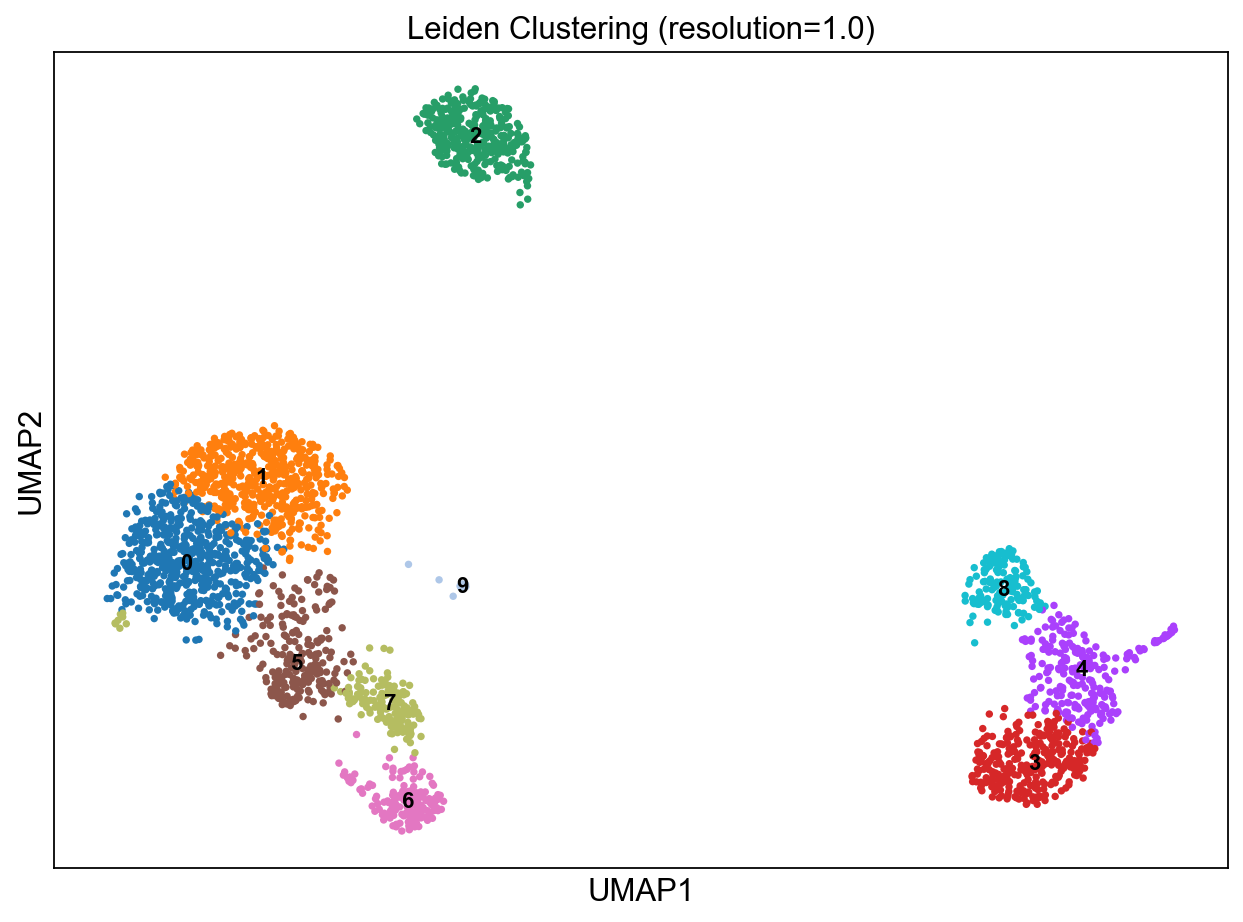

Identified 10 clusters


In [8]:
# Visualize clusters on UMAP
fig, ax = plt.subplots(figsize=(8, 6))

sc.pl.umap(
    adata,
    color='leiden_1.0',
    legend_loc='on data',
    legend_fontsize=10,
    ax=ax,
    show=False,
    title='Leiden Clustering (resolution=1.0)'
)

plt.tight_layout()
plt.savefig(f'{results_dir}04_leiden_clusters_res1.0.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Identified {adata.obs['leiden_1.0'].nunique()} clusters")

## 4. Test Multiple Resolutions

Let's try different resolutions to see how granularity changes.

In [9]:
# Test multiple resolutions
resolutions = [0.4, 0.8, 1.0, 1.5, 2.0]

for res in resolutions:
    sc.tl.leiden(adata, resolution=res, key_added=f'leiden_{res}')
    n_clusters = adata.obs[f'leiden_{res}'].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

running Leiden clustering
    finished: found 7 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.4: 7 clusters
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 0.8: 9 clusters
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 1.0: 10 clusters
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_1.5', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 1.5: 11 clusters
running Leiden clustering
    finished: found 14 clusters and added
    'leiden_2.0', the cluster labels (adata.obs, categorical) (0:00:00)
Resolution 2.0: 14 clusters


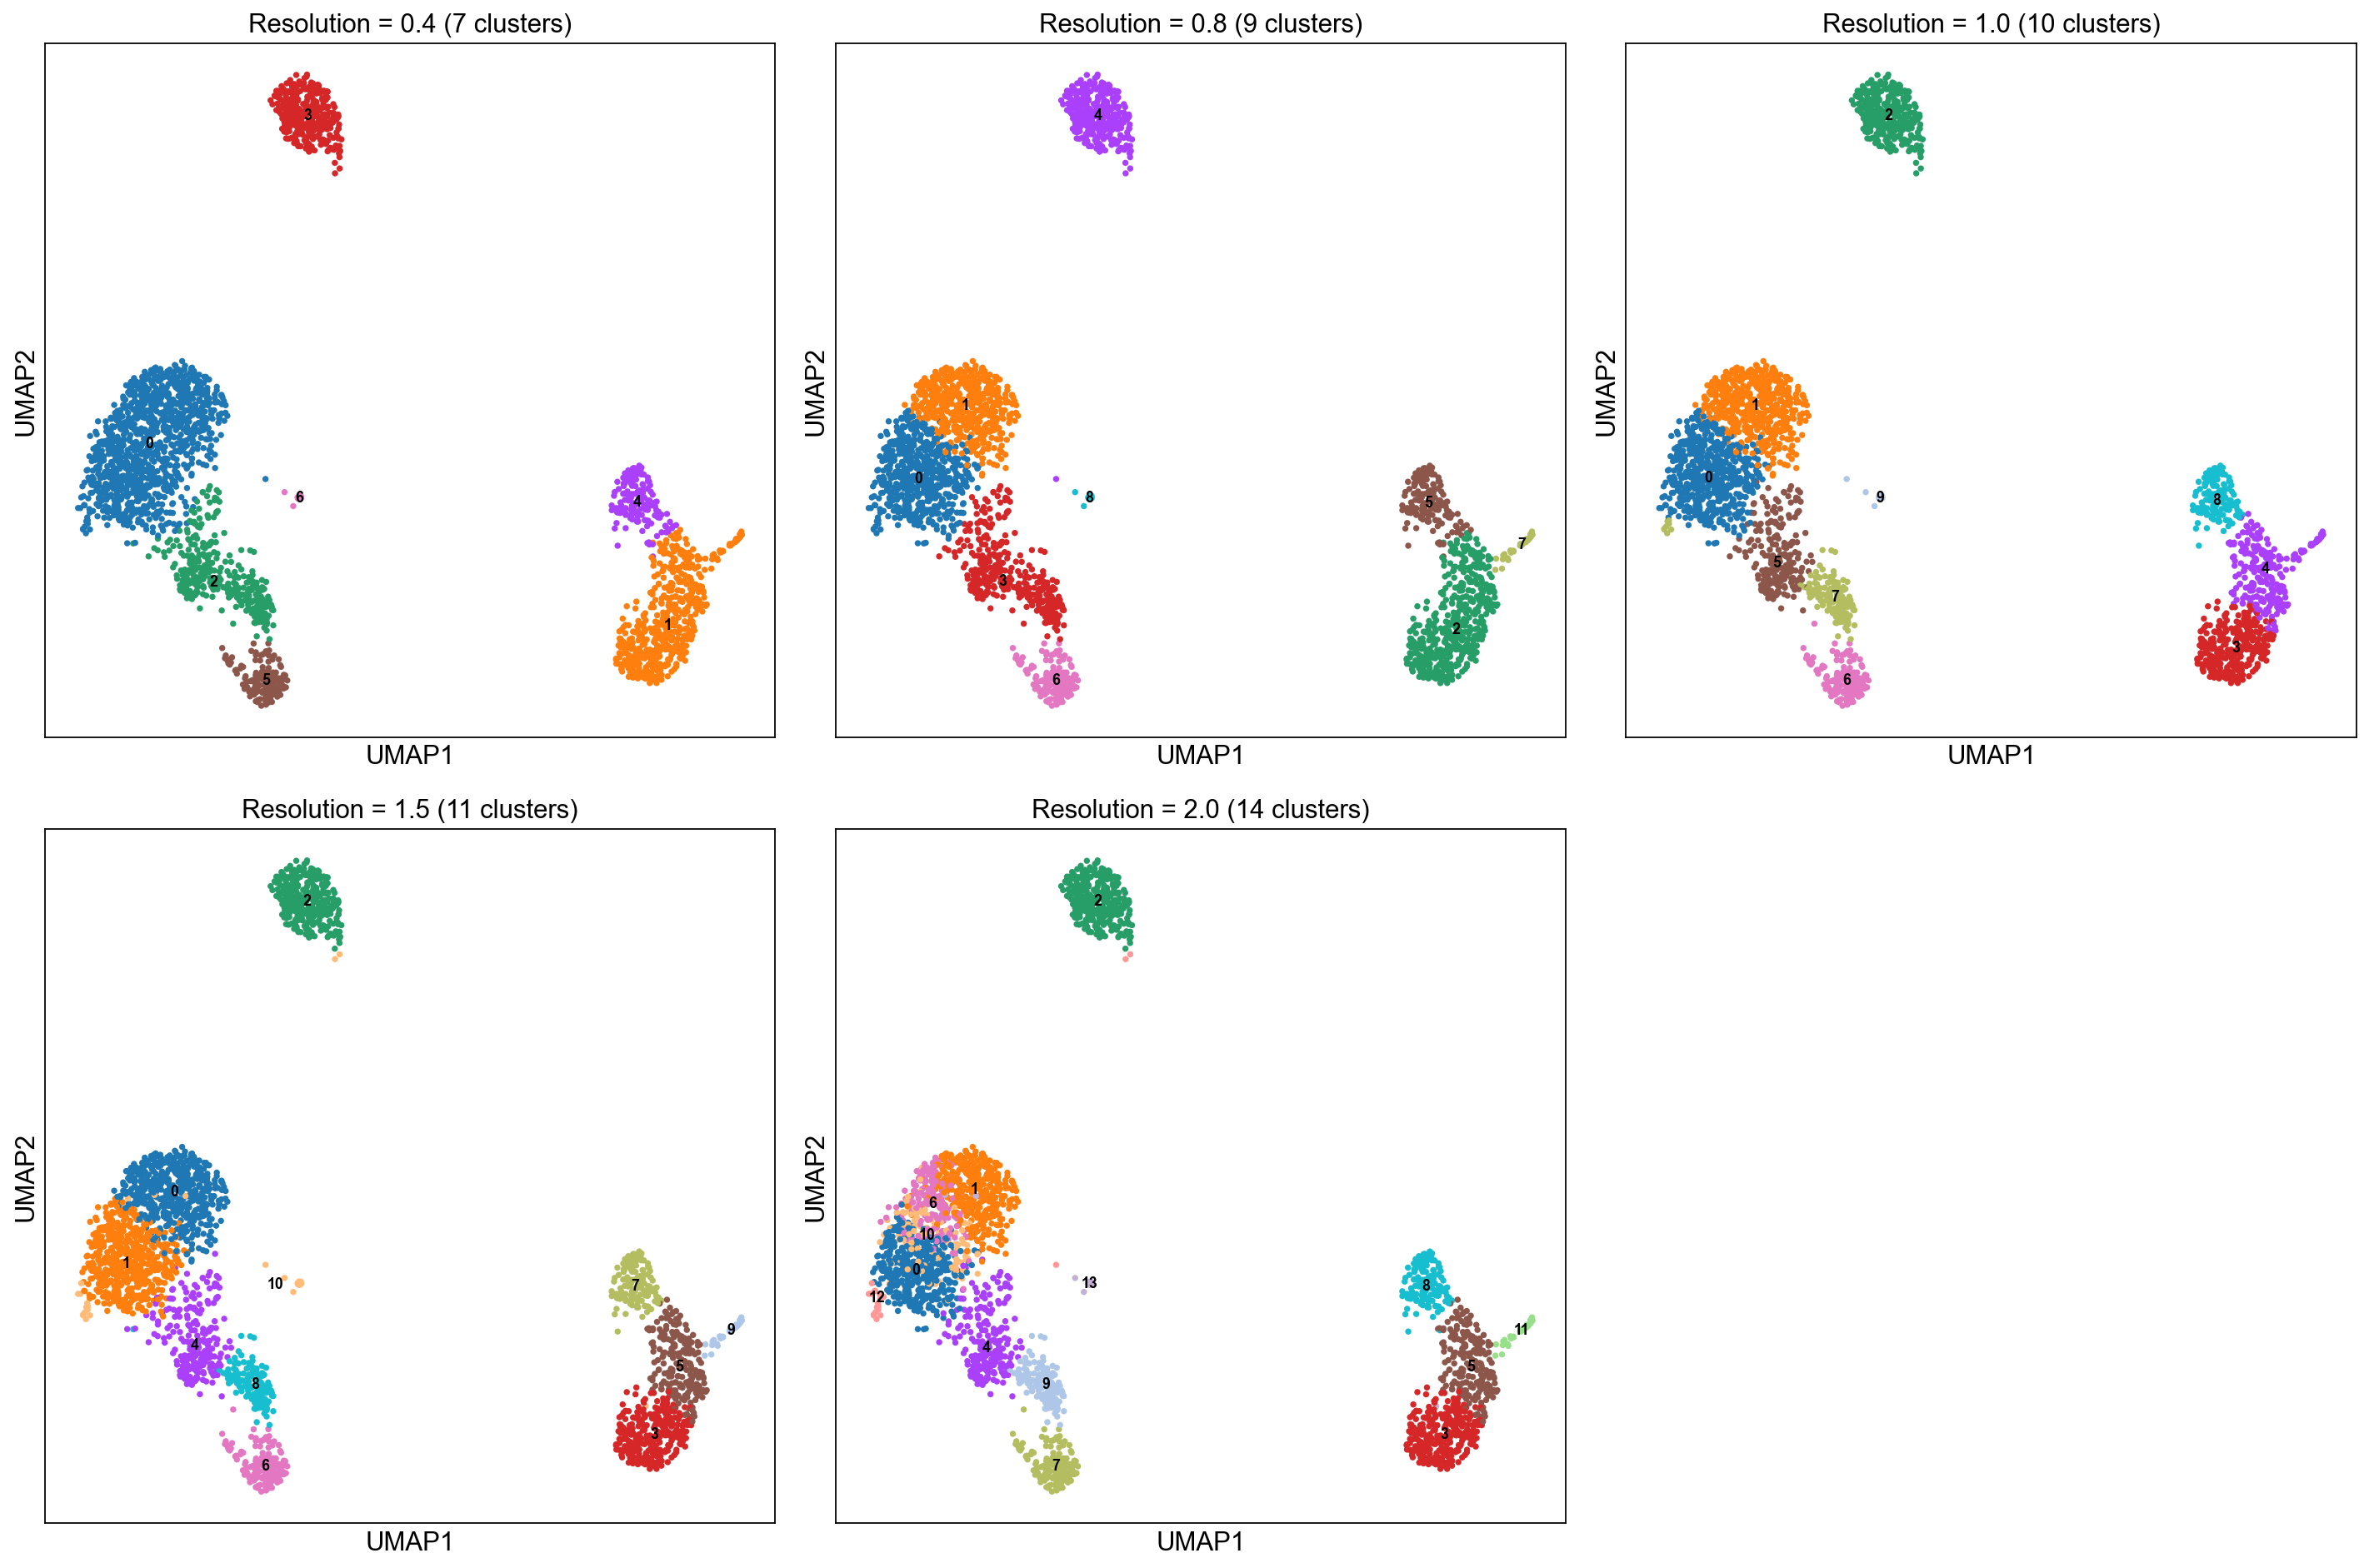

Multiple resolutions compared


In [11]:
# Visualize multiple resolutions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, res in enumerate(resolutions):
    sc.pl.umap(
        adata,
        color=f'leiden_{res}',
        legend_loc='on data',
        legend_fontsize=8,
        ax=axes[idx],
        show=False,
        title=f'Resolution = {res} ({adata.obs[f"leiden_{res}"].nunique()} clusters)'
    )

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.savefig(f'{results_dir}04_leiden_multiple_resolutions.png', dpi=150, bbox_inches='tight')
plt.show()

print("Multiple resolutions compared")

## 5. Clustering Quality Metrics

### Silhouette Score

Measures how well-separated clusters are:
- **Score close to 1**: Clusters are well-separated
- **Score close to 0**: Clusters overlap
- **Score < 0**: Cells might be in wrong cluster

**Note**: Lower scores are common in single-cell data due to continuous transitions between cell states.

In [13]:
# Compute silhouette scores for different resolutions
from sklearn.metrics import silhouette_score

print("=" * 60)
print("SILHOUETTE SCORES")
print("=" * 60)

for res in resolutions:
    labels = adata.obs[f'leiden_{res}'].astype(int)
    score = silhouette_score(adata.obsm['X_pca'][:, :30], labels)
    n_clusters = adata.obs[f'leiden_{res}'].nunique()
    print(f"Resolution {res:4.1f}: Score = {score:.3f} ({n_clusters:2d} clusters)")

print("Higher score = better separation (but not always biologically meaningful!)")

SILHOUETTE SCORES
Resolution  0.4: Score = 0.236 ( 7 clusters)
Resolution  0.8: Score = 0.160 ( 9 clusters)
Resolution  1.0: Score = 0.147 (10 clusters)
Resolution  1.5: Score = 0.139 (11 clusters)
Resolution  2.0: Score = 0.119 (14 clusters)
Higher score = better separation (but not always biologically meaningful!)


## 6. Cluster Composition

Analyze how QC metrics distribute across clusters.

**Good clustering**: QC metrics should be relatively uniform across clusters

**Bad clustering**: One cluster has very different QC metrics (technical artifact!)

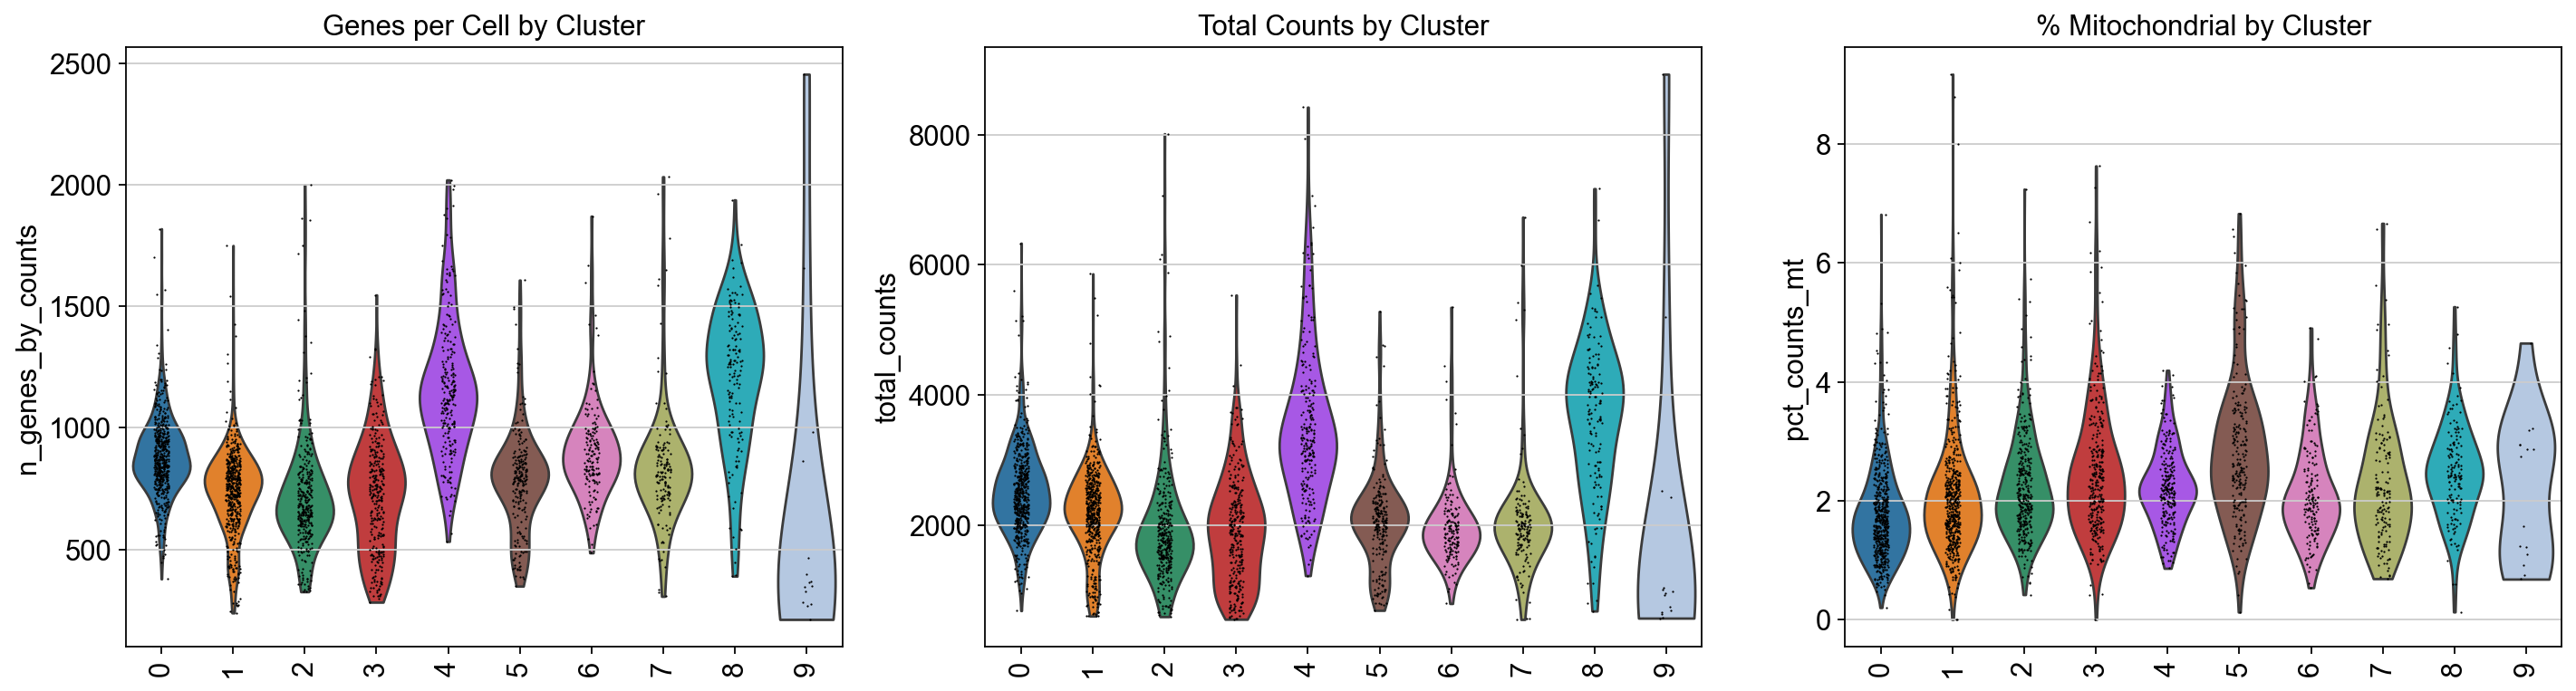

Cluster QC composition analyzed
Look for outlier clusters with very different QC metrics


In [16]:
# Analyze cluster composition (using resolution 1.0)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Number of genes per cluster
sc.pl.violin(
    adata,
    keys='n_genes_by_counts',
    groupby='leiden_1.0',
    ax=axes[0],
    show=False,
    rotation=90
)
axes[0].set_title('Genes per Cell by Cluster')

# Total counts per cluster
sc.pl.violin(
    adata,
    keys='total_counts',
    groupby='leiden_1.0',
    ax=axes[1],
    show=False,
    rotation=90
)
axes[1].set_title('Total Counts by Cluster')

# % Mitochondrial per cluster
sc.pl.violin(
    adata,
    keys='pct_counts_mt',
    groupby='leiden_1.0',
    ax=axes[2],
    show=False,
    rotation=90
)
axes[2].set_title('% Mitochondrial by Cluster')

plt.tight_layout()
plt.savefig(f'{results_dir}04_cluster_qc_composition.png', dpi=150, bbox_inches='tight')
plt.show()

print("Cluster QC composition analyzed")
print("Look for outlier clusters with very different QC metrics")

## 7. Cluster Sizes
Check if clusters are balanced or if some are very small/large.

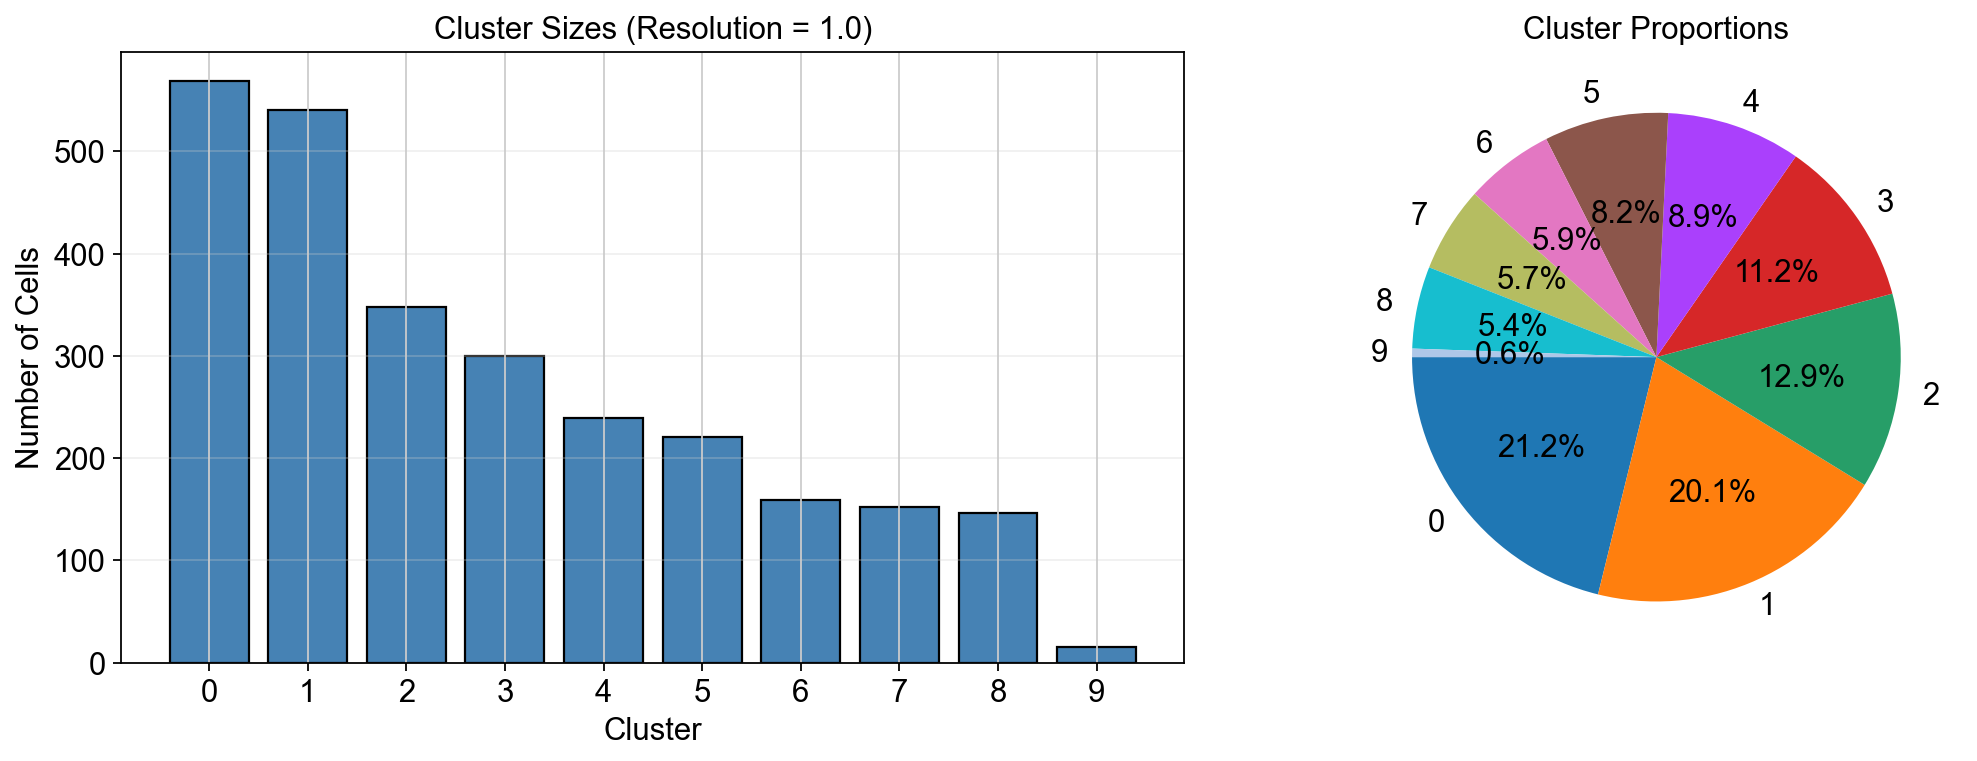

Cluster size distribution
Smallest cluster: 15 cells
Largest cluster: 569 cells
Mean cluster size: 269 cells
The QC plot looks good overall — most clusters are consistent.
Cluster 9 is a potential QC outlier → likely doublets or low-quality cells.


In [28]:
# Cluster size distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
cluster_sizes = adata.obs['leiden_1.0'].value_counts().sort_index()
axes[0].bar(cluster_sizes.index.astype(str), cluster_sizes.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Number of Cells')
axes[0].set_title('Cluster Sizes (Resolution = 1.0)')
axes[0].grid(axis='y', alpha=0.3)

# Pie chart
axes[1].pie(cluster_sizes.values, labels=cluster_sizes.index, autopct='%1.1f%%', startangle=180)
axes[1].set_title('Cluster Proportions')

plt.tight_layout()
plt.savefig(f'{results_dir}04_cluster_sizes.png', dpi=150, bbox_inches='tight')
plt.show()

print("Cluster size distribution")
print(f"Smallest cluster: {cluster_sizes.min()} cells")
print(f"Largest cluster: {cluster_sizes.max()} cells")
print(f"Mean cluster size: {cluster_sizes.mean():.0f} cells")
print(f"The QC plot looks good overall — most clusters are consistent.")
print(f"Cluster 9 is a potential QC outlier → likely doublets or low-quality cells.")




## 8. Choose Final Resolution

Based on:
1. **Biological knowledge**: Expected number of cell types
2. **Visual inspection**: Do clusters look reasonable on UMAP?
3. **Silhouette score**: Higher is better (but not the only criterion)
4. **Cluster sizes**: Avoid too many tiny clusters

**For PBMC data**: We expect ~8-10 major cell types, so **resolution = 1.0** is a good choice.

In [29]:
# Set final clustering
adata.obs['leiden'] = adata.obs['leiden_1.0']

print("=" * 60)
print("FINAL CLUSTERING")
print("=" * 60)
print(f"Resolution: 1.0")
print(f"Number of clusters: {adata.obs['leiden'].nunique()}")
print(f"\nCluster sizes:")
print(adata.obs['leiden'].value_counts().sort_index())

FINAL CLUSTERING
Resolution: 1.0
Number of clusters: 10

Cluster sizes:
leiden
0    569
1    540
2    348
3    300
4    239
5    221
6    159
7    152
8    146
9     15
Name: count, dtype: int64


## 9. Save Clustered Data

Save the data with cluster assignments for downstream analysis.

In [30]:
# Save clustered data
adata.write(f'{data_dir}pbmc3k_clustered.h5ad')

print("✅ Clustered data saved!")
print(f"File: {data_dir}pbmc3k_clustered.h5ad")
print(f"\n📊 Final state:")
print(f"  - Cells: {adata.n_obs}")
print(f"  - Genes: {adata.n_vars}")
print(f"  - Clusters: {adata.obs['leiden'].nunique()}")

✅ Clustered data saved!
File: ../data/pbmc3k_clustered.h5ad

📊 Final state:
  - Cells: 2689
  - Genes: 13671
  - Clusters: 10


## Summary

### What we accomplished:

1. **Loaded data** with PCA, UMAP, and neighborhood graph
2. **Performed Leiden clustering** (graph-based algorithm)
3. **Tested multiple resolutions** (0.4 to 2.0)
4. **Visualized clusters** on UMAP
5. **Evaluated clustering quality** (silhouette scores)
6. **Analyzed cluster composition** (QC metrics distribution)
7. **Examined cluster sizes** (balanced vs imbalanced)
8. **Chose final resolution** (1.0 → ~8-10 clusters)
9. **Saved clustered data** for marker gene identification

### Final Clustering:

- **Algorithm**: Leiden
- **Resolution**: 1.0
- **Number of clusters**: 10 
- **Based on**: 30 PCs from 2,000 HVGs

### Key Insights:

- **Resolution matters**: Low = broad types, High = subtypes
- **No "perfect" resolution**: Depends on biological question
- **QC check**: Clusters should not be driven by technical artifacts
- **Silhouette score**: Useful but not the only criterion

### What's Next?

Now that we have clusters, we need to **identify what they are**!

### Next Steps: Notebook 05 - Marker Gene Identification

In the next notebook, we will:
1. **Find marker genes** for each cluster
2. **Differential expression testing**
3. **Visualize top markers**
4. **Prepare for cell type annotation**

---

**🎉 Excellent work! Your cells are now grouped into biologically meaningful clusters!**